<a href="https://colab.research.google.com/github/weicuivt/DL2019Fall/blob/master/HW1/ECE_CS_6524_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE-6524 / CS-6524 Deep Learning
# Assignment 1

In this assignment, **you need to complete the following three sectoins**:
1. SVM Classifier
    - Calculating loss and gradient
2. Linear Classfier with Softmax 
    - Calculating loss and gradient
3. Simple Neural Network with Multilayer Perceptrons
    - Read the forward and backward propogation
    - Experiment with simple NN

This assignment is inspired and adopted from Stanford CS231n, UIUC Deep Learning course and Deep Learning Lab from Professor Vicente Ordonez at the University of Virginia.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Zip BOTH the PDF file and this notebook. Rem
8. Submit your zipped file.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 905808996
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. numupy
2. matplotlib
3. scipy
```
All packages above can be installed through `pip install`.

In addition, you will need to have [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in your `cifar10/cifar-10-batches-py` folder. We provide a bash script `cifar10/get_dataset.sh` to help you download and unpack the dataset.

Once you are done with the things above, you can proceed to execute the following cells:

In [ ]:
import random
import numpy as np
from data_process import get_CIFAR10_data

import math
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline


# Loading CIFAR-10

In the following cells, we would first load the CIFAR10 dataset, and prepare them for our classifier:

In [ ]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 1000

Now, we visualize the dataset to get a better idea of it.

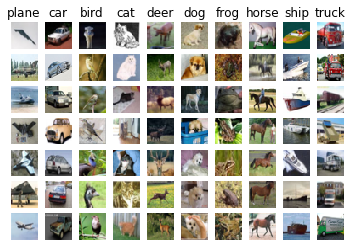

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

We then subtract all the images with the **mean image** of the training set. This trick is commonly used in Computer Vision community, as it arranges the features into a range that is more manageable for the models.

In [ ]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Now, we convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector. This allows us to feed the data into our classifiers.

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

Here, we concatenate all the features with ones. This trick is particularly convenient, as in this case, we only need to deal with a single weight matrix $W$ instead of both $W$ and bias $b$ in our training code.

In [ ]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [ ]:
# you should get the following output:
# (49000, 3073)
# (1000, 3073)
# (1000, 3073)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3073)
(1000, 3073)
(1000, 3073)


### Calculate Classification Accuracy

Here is a simple helper function for calculation the classification accuracy:

In [ ]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

# Section 1. Support Vector Machines (with SGD) [30 pts]

In this section, you will need to implement a **soft margin SVM** for a **multi-class classification problem**. In the soft margin SVM, you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

## 1.1. Implementing SVM with SGD [25 pts]

Recall that the multiclass SVM loss can be written as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = \sum_{j\neq y_i} \left[ \max(0, s_j - s_{y_i} + margin) \right]
\end{gathered}
\end{align}
where $s={s_j}$ is the vector of prediction scores of all class, $s_j$ is the prediction score for class $j$, and $y_i$ is the groud truth class label. The margin is usually set to 1. Now, to learn the weights $W$, we can differentiate the function $L_i$ to get the gradient:
\begin{equation}
\begin{gathered}
\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) \right) x_i\\
\end{gathered}
\end{equation}
where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise, and $w_j$ represents the row $j$ in your weight matrix $W$. To implement this, you’d simply count the number of classes that didn’t meet the desired margin 1 (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Note that, in the equation above, we are only calculating the gradient with respect to the row of $W$ that corresponds to the correct class $y_i$. For the other rows $j\neq y_i$, we have:
\begin{equation}
\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) x_i
\end{equation}
Now, we have derived the gradient expression above, it is time to turn these equations into the actual running code.
We provide a template for implementing your SVM classfier below. You have to fill in the **TODO** part, and train your classifier.

In [ ]:
 
class SVM():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
        
    def calc_grad_and_loss(self, X_train, y_train, reg, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
        """
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        
        tw=self.w.transpose()
        
        grad_w=np.zeros((self.output_size,self.input_size))
        loss=0.0
        
        for i in range(len(X_train)):
            tgrad_w=np.zeros((self.output_size,self.input_size))
            temp=0.0
            
            for j in range(self.output_size):
                tloss=np.dot(tw[j]-tw[y_train[i]], X_train[i]) + margin
                if j!=y_train[i] and tloss > 0.0:
                    tgrad_w[j] = X_train[i]
                    temp+=1
                    loss+=tloss
                            
            tgrad_w[y_train[i]] = - temp * X_train[i]
            grad_w+=tgrad_w
            
        grad_w=grad_w.transpose()/len(X_train) + reg*2.0*self.w
        loss=loss/len(X_train)+reg*np.sum(self.w)
    
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200):
        """
        Train SVM classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 500 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        
        pred = []
        for i in range(len(X_test)):
            s=np.dot(self.w.transpose(), X_test[i])
            pred.append(np.argmax(s))

        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred
    


### Train your SVM
Now, train your SVM classifier. You should expect the loss decreases as the training goes on.

In [ ]:
print(y_train[2])

9


In [ ]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
print(num_features, num_classes)
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,)


3073 10
Iter 500/1500 - loss: -432.72648662217205 
Iter 1000/1500 - loss: -261.2253924869519 
Iter 1500/1500 - loss: -156.74313272613335 


### Plot the Loss Curve
Plotting the loss curve is a proper etiquette for Machine Learning/Deep Learning practitioner.

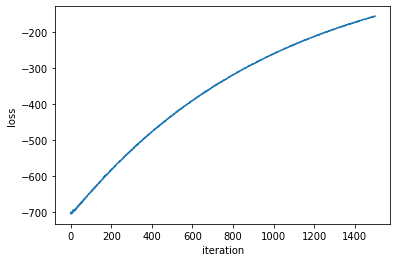

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an training/validation accuracy around 34%-35%.

In [ ]:
pred_svm = svm.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

The training accuracy is given by : 37.114286
The validation accuracy is given by : 38.600000


## Section 1.2. Improve your SVM [5 pts]
Now, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.**

Iter 500/500 - loss: 8.771002218079852 
Iter 500/500 - loss: 8.002548597534435 
Iter 500/500 - loss: 7.394684326389536 
Iter 500/500 - loss: 7.655969168114852 
Iter 500/500 - loss: 7.928315708052368 
[26.55, 25.86, 25.919999999999998, 25.540000000000003, 25.97]
Iter 500/500 - loss: 15.228036242289061 
Iter 500/500 - loss: -9.201583916035098 
Iter 500/500 - loss: 16.238737239436546 
Iter 500/500 - loss: -11.40044320443876 
Iter 500/500 - loss: 0.2023618401052829 
[26.63, 26.810000000000002, 26.790000000000003, 25.790000000000003, 27.189999999999998]
Iter 500/500 - loss: -136.2186348407758 
Iter 500/500 - loss: 38.31970967496497 
Iter 500/500 - loss: -167.77652531109203 
Iter 500/500 - loss: -212.46789997194674 
Iter 500/500 - loss: -165.3930853244278 
[26.69, 27.200000000000003, 26.619999999999997, 27.04, 26.950000000000003]
Iter 500/500 - loss: -376.18642147238205 
Iter 500/500 - loss: -344.97852725525826 
Iter 500/500 - loss: -64.46325357750025 
Iter 500/500 - loss: 158.54041854551346

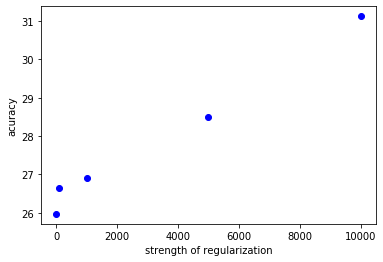

In [ ]:
# How can you improve it?

#Answer:
# 1. Improvence: search better strength of regularization and keep other parameters unchanged. 
# 2. Method: 3 fold cross-validation.
# 3. code: 

from sklearn.model_selection import KFold

reg_list=[1,1e2,1e3,5e3,1e4]
acu_list=[]

Xdata=np.concatenate((X_train, X_val), axis=0)
ydata=np.concatenate((y_train, y_val), axis=0)

n_iter = 500
batch_size = 200

for i in range(len(reg_list)):
    
    kf = KFold(n_splits=5)
    ttt_list=[]
    
    for train_index, val_index in kf.split(Xdata):
        
        X_train, X_val = Xdata[train_index], Xdata[val_index]
        y_train, y_val = ydata[train_index], ydata[val_index]
        
        num_classes = np.max(y_train) + 1
        num_features = X_train.shape[1]
        svm = SVM(num_features, num_classes)
        loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=reg_list[i], n_iters=500,)
        pred_svm = svm.predict(X_val)
        ttt_list.append(get_acc(pred_svm, y_val))
        
    print(ttt_list)
    acu_list.append(np.sum(ttt_list)/5.0)
    

print(acu_list)

plt.plot(reg_list,acu_list,'bo');
plt.ylabel('acuracy');
plt.xlabel('strength of regularization');
    
    

### Test SVM
Finally, evaluate the testing accuracy of your SVM:

In [ ]:
# Run linear classifier again with best regularization
# Data set is sperated with 49000 and 1000 as train and validate data 

X_train, y_train = Xdata[0:49000], ydata[0:49000]
        
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=reg_list[np.argmax(acu_list)], n_iters=1500,)

pred_svm = svm.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_svm, y_test)))

Iter 500/500 - loss: -589.7616684289617 
The testing accuracy is given by : 31.700000


# Section 2. Softmax Classifier (with SGD) [30 pts]

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. 

## Section 2.1. Implement the Softmax Classifier [25 pts]
Recall that, from the lecture, we can write down the loss function as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = -\log\left({\frac{e^{s_{y_i}}} {\sum_j e^{s_j}} }\right)
\end{gathered}
\end{align}

And, through some calculations, we can obtain the expression for the gradient:
\begin{align}
\nabla_{w_{l}} L_i = \left(\frac{e^{w_l^Tx_i}} {\sum_j e^{w_j^Tx_i}} - \mathbb{1}\left(y_i=l\right)\right) x_i\\
\end{align}


The softmax classifier also has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

Same as the previous section, we provide a template for you to implement your classifier:

In [ ]:
 class Softmax_Classfier():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
    
    def softmax(self, logits):
        ################################################################################
        # TODO:                                                                        #
        # Implement the softmax function here.                                         #
        ################################################################################
        plist=[]
        for j in range(self.output_size):
            plist.append(math.exp(logits[j]))
        tot=np.sum(plist)
        probs=plist/tot

        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return probs
    
    def calc_grad_and_loss(self, X_train, y_train, reg_const, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
         """ 
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        
        tw=self.w.transpose()
        grad_w=np.zeros((self.output_size,self.input_size))
        loss=0.0
        
        
        for i in range(len(X_train)):
            sj=[]
            for j in range(self.output_size):
                sj.append(np.dot(tw[j], X_train[i]))
            prob=self.softmax(sj)
            
            loss=loss-math.log(prob[y_train[i]])
            
            tgrad_w=np.zeros((self.output_size,self.input_size))
            for j in range(self.output_size):
                if j== y_train[i]:
                    tgrad_w[j] = (prob[j]-1.0)*X_train[i]
                else: 
                    tgrad_w[j] = prob[j]*X_train[i]
            grad_w+=tgrad_w
            
        grad_w=grad_w.transpose()/len(X_train)+reg_const*2.0*self.w
        loss=loss/len(X_train)+reg_const*np.sum(self.w)
     
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200):
        """
        Train softmax classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 500 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        
        pred = []
        for i in range(len(X_test)):
            s=np.dot(self.w.transpose(), X_test[i])
            pred.append(np.argmax(s))

        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred


In [ ]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
print(num_features, num_classes)
softmax_classifier = Softmax_Classfier(num_features, num_classes)
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,)

3073 10
Iter 500/1500 - loss: 103.76262737568847 
Iter 1000/1500 - loss: 63.67548997577142 
Iter 1500/1500 - loss: 39.244628669067936 


Again, plot the loss:

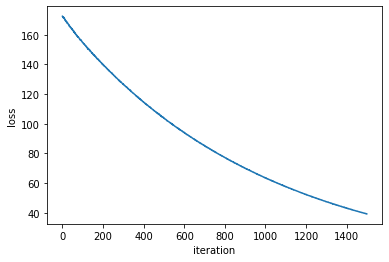

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an accuracy around 29%.

In [ ]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

The training accuracy is given by : 33.412245
The validation accuracy is given by : 33.770000


## Section 2.1. Improve your Softmax Classifier [5 pts]
Again, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.** In addition, <span style="color:red">**We expect to see an accuracy around 34% after the improvement.**</span>


Iter 500/500 - loss: 551.8324699557352 
Iter 500/500 - loss: 555.4606795600063 
Iter 500/500 - loss: 852.3086818234756 
Iter 500/500 - loss: -580.7070272883599 
Iter 500/500 - loss: -239.29622126453523 
[28.228813559322035, 28.237288135593218, 29.567796610169488, 28.8728813559322, 28.474576271186443]
Iter 500/500 - loss: 1012.0844434727504 
Iter 500/500 - loss: -712.6902970005781 
Iter 500/500 - loss: 1043.271725923148 
Iter 500/500 - loss: 176.85854183790312 
Iter 500/500 - loss: -49.079481961170984 
[28.440677966101696, 28.567796610169495, 28.118644067796613, 28.559322033898304, 28.720338983050848]
Iter 500/500 - loss: 370.34167745037064 
Iter 500/500 - loss: 85.29395673074956 
Iter 500/500 - loss: -94.36756613167879 
Iter 500/500 - loss: -504.65427829109314 
Iter 500/500 - loss: -642.3871657388495 
[29.686440677966104, 27.74576271186441, 28.720338983050848, 28.847457627118644, 29.3728813559322]
Iter 500/500 - loss: 182.93158329423122 
Iter 500/500 - loss: -324.1029871664444 
Iter 50

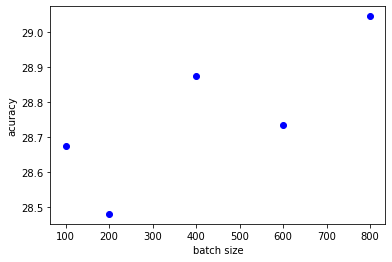

In [ ]:
# Get the accuracy to above 34%!


#Answer:
# 1. Improvence: search better number of training batches and keep other parameters unchanged. 
# 2. Method: 5 fold cross-validation.
# 3. code: 

from sklearn.model_selection import KFold

n_iter = 500
batch_size_list=[100,200,400,600,800]
acu_list=[]

Xdata=np.concatenate((X_train, X_val), axis=0)
ydata=np.concatenate((y_train, y_val), axis=0)


for i in range(len(batch_size_list)):
    kf = KFold(n_splits=5)
    ttt_list=[]
    
    for train_index, val_index in kf.split(Xdata):
        
        X_train, X_val = Xdata[train_index], Xdata[val_index]
        y_train, y_val = ydata[train_index], ydata[val_index]
        
        num_classes = np.max(y_train) + 1
        num_features = X_train.shape[1]
        svm = SVM(num_features, num_classes)
        loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=500,batch_size=batch_size_list[i])
        pred_svm = svm.predict(X_val)
        ttt_list.append(get_acc(pred_svm, y_val))
        
    print(ttt_list)
    acu_list.append(np.sum(ttt_list)/5.0)
    
print(acu_list)
plt.plot(batch_size_list,acu_list,'bo');
plt.ylabel('acuracy');
plt.xlabel('batch size');


### Testing Softmax

Finally, evaluate the testing accuracy.

In [ ]:
# Run linear classifier again with best batch size
# Data set is sperated with 49000 and 1000 as train and validate data 

X_train, y_train = Xdata[0:49000], ydata[0:49000]
        
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,batch_size=batch_size_list[np.argmax(acu_list)])

pred_softmax = softmax_classifier.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

Iter 500/500 - loss: 137.2293516224296 
The testing accuracy is given by : 33.800000


# Section 3. Multilayer Perceptron (MLP)
In this section, we present you a modified version of simple neural network from Professor Vicente Ordonez at the University of Virginia. You job is to read through the implementation (optional, but highly recommended), and try the MLP classifier. For additional resources on understanding forward and backpropagation, you can check the materials here: http://cs231n.github.io/optimization-2/

Consider a single-layer supervised neural network that has 4 inputs and 3 outputs. First, let's review the skeleton of a single linear layer neural network. The inputs of the network are the variables $x_1, x_2, x_3, x_4$, or the input vector $\mathbf{x}=[x_1, x_2, x_3, x_4]$, the outputs of the network are $\widehat{y}_1,\widehat{y}_2,\widehat{y}_3$, or the output vector $\widehat{\mathbf{y}}=[$$\widehat{y}$$_1,\widehat{y}_2,\widehat{y}_3]$:

<img src="fig/1_layer_fig.png" width="450"/>

The given $j$-th output $\widehat{y}_j$ of this single linear layer + activation function is computed as follows:

$$\widehat{y}_j= \text{sigmoid}(w_{1j}x_1 + w_{2j}x_2 + w_{3j}x_3 + w_{4j}x_4 + b_j) = \text{sigmoid}\Big(\sum_{i=1}^{i=4}w_{ij}x_{i} + b_j\Big)$$

In matrix notation, this would be: 

\begin{equation}
\begin{bmatrix}
  \widehat{y}_{1} \\ 
  \widehat{y}_{2} \\
  \widehat{y}_{3} 
\end{bmatrix}^T=\mathbf{Sigmoid}\Bigg(
\begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4}
\end{bmatrix}^T
\begin{bmatrix}
  w_{1,1} & w_{1,2} & w_{1,3}\\
  w_{2,1} & w_{3,2} & w_{2,3}\\
  w_{3,1} & w_{3,2} & w_{3,3}\\
  w_{4,1} & w_{4,2} & w_{4,3}
\end{bmatrix}
+
\begin{bmatrix}
  b_{1} \\
  b_{2} \\
  b_{3}
\end{bmatrix}^T\Bigg)
\end{equation}

or more compactly:

\begin{equation}
\widehat{\mathbf{y}}^T = \mathbf{Sigmoid}(\mathbf{x}^T \cdot \mathbf{W} + \mathbf{b}^T)
\end{equation}

The element-wise sigmoid function is: $\mathbf{Sigmoid}(\mathbf{x}) = 1 \;/\; (1 + exp(-\mathbf{x}))$, or alternatively: $\mathbf{Sigmoid}(\mathbf{x}) = exp(\mathbf{x})\;/\;(1 + exp(\mathbf{x}))$. Here the sigmoid is separated logically into an activation layer $\sigma(x)$ and a linear layer $\text{linear}(3,4)$ as illustrated in figure. 

Training these weights $\mathbf{W}$ and biases $\mathbf{b}$ requires having many training pairs $(\widehat{\mathbf{y}}^{(m)}, \mathbf{x}^{(m)})$. The inputs $\mathbf{x}$ can be the pixels of an image, indices of words, the entries in a database, and the outputs $\widehat{\mathbf{y}}$ can also be literally anything, including a number indicating a category, a set of numbers indicating the indices of words composing a sentence, an output image itself, etc.

## 3.1. Forward-propagation

Computing the outputs $\widehat{\mathbf{y}}$ from the inputs $\mathbf{x}$ in this network composed of a single linear layer, and a sigmoid layer, is called forward-propagation. Below is the code that implements these two operations:

In [ ]:
import numpy as np
import numpy.matlib

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        
    # y = Wx + b
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def getParameters(self):
        return [self.weight, self.bias]

# Let's test the composition of the two functions (forward-propagation in the neural network).
x1 = np.array([[1, 2, 2, 3]])
y_hat1 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x1))
print('x[1] = '+ str(x1))
print('y_hat[1] = ' + str(y_hat1) + '\n')

# Let's test the composition of the two functions (forward-propagation in the neural network).
x2 = np.array([[4, 5, 2, 1]])
y_hat2 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x2))
print('x[2] = '+ str(x2))
print('y_hat[2] = ' + str(y_hat2) + '\n')

# We can also compute both at once, which could be more efficient since it requires a single matrix multiplication.
x = np.concatenate((x1, x2), axis = 0)
y_hat = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x))
print('x = ' + str(x))
print('y_hat = ' + str(y_hat))

x[1] = [[1 2 2 3]]
y_hat[1] = [[0.49911085 0.50182834 0.50064013]]

x[2] = [[4 5 2 1]]
y_hat[2] = [[0.50095754 0.50055643 0.49829759]]

x = [[1 2 2 3]
 [4 5 2 1]]
y_hat = [[0.49902246 0.50143699 0.50057282]
 [0.50137117 0.50193738 0.50150044]]


## 3.2. Loss functions.

After computing the output predictions $\widehat{\mathbf{y}}$ it is necessary to compare these against the true values of $\mathbf{y}$. Let's call these true, correct, or desired values $\mathbf{y}$. Typically, a simple loss or cost function is used to measure the degree by which the prediction $\widehat{\mathbf{y}}$ is wrong with respect to $\mathbf{y}$. A common loss function for regression is the sum of squared differences between the prediction and its true value. Assuming a prediction $\widehat{\mathbf{y}}^{(d)}$ for our training sample $\mathbf{x}^{(d)}$ with true value $\mathbf{y}^{(d)}$, then the loss can be computed as:

$$loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)}) = (\widehat{y}^{(d)}_1 - y^{(d)}_1)^2 + (\widehat{y}^{(d)}_2 - y^{(d)}_2)^2 + (\widehat{y}^{(d)}_3 - y^{(d)}_3)^2 = \sum_{j=1}^{j=3}(\widehat{y}^{(d)}_j - y^{(d)}_j)^2$$

The goal is to modify the parameters [$\mathbf{W}, \mathbf{b}$] in the Linear layer so that the value of $loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$ becomes as small as possible for all training samples in a set $D=\{(\mathbf{x}^{(d)},\mathbf{y}^{(d)})\}$. This would in turn ensure that predictions $\widehat{\mathbf{y}}$ are as similar as possible to the true values $\mathbf{y}$. To achieve this we need to minimize the following function:

$$\mathcal{L}(\mathbf{W}, \mathbf{b}) = \sum_{d=1}^{d=|D|} loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$$

The only two variables for our model in the function $\mathcal{L}(\mathbf{W}, \mathbf{b})$ are $\mathbf{W}$ and $\mathbf{b}$, this is because the training dataset $D$ is fixed. Finding the values of $\mathbf{W}$ and $\mathbf{b}$ that minimize the the loss, particularly for complex functions, is typically done using gradient based optimization, like Stochastic Gradient Descent (SGD). 

In [ ]:
class nn_MSECriterion:  # MSE = mean squared error.
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))

# Let's test the loss function.
y_hat = np.array([[0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33]])
y_true = np.array([[0.25, 0.25, 0.25], [0.33, 0.33, 0.33], [0.77, 0.77, 0.77], [0.80, 0.80, 0.80]])

nn_MSECriterion().forward(y_hat, y_true)

1.6271000000000002

## 3.3. Backward-propagation (Backpropagation)

As we discussed in class, backpropagation is just applying the chain-rule in calculus to compute the derivative of a function which is the composition of many functions (this is essentially definition of the neural network). 

Below is the implementation of required derivative computations for our simple network. You are highly advised to derive the derivatives implemented here to make sure you understand how one arrives at them. 

In [ ]:
# This is referred above as f(u).

class nn_MSECriterion:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels):
        num_samples = labels.shape[0]
        return 2 * (predictions - labels)
    
# This is referred above as g(v).
class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x))
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

# This is referred above as h(W, b)
class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)
        
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x, gradOutput):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        #self.gradBias = np.copy(gradOutput)
        self.gradBias = np.copy(np.sum(gradOutput, axis=0))
        # return dL/dx = dh/dx * dL/dv
        return np.dot(gradOutput, self.weight.T)
    
    def getParameters(self):
        params = [self.weight, self.bias]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams
    
# Let's test some dummy inputs for a full pass of forward and backward propagation.
x1 = np.array([[1, 2, 2, 3]])
y1 = np.array([[0.25, 0.25, 0.25]])

# Define the operations.
linear = nn_Linear(4, 3)  # h(W, b)
sigmoid = nn_Sigmoid()  # g(v)
loss = nn_MSECriterion()  # f(u)

# Forward-propagation.
lin = linear.forward(x1)
y_hat = sigmoid.forward(lin)
loss_val = loss.forward(y_hat, y1) # Loss function.

# Backward-propagation.
dy_hat = loss.backward(y_hat, y1)
dlin = sigmoid.backward(lin, dy_hat)
dx1 = linear.backward(x1, dlin)

print('\n num_samples = ' + str(y1.shape[0]))

# Show parameters of the linear layer.
print('\nW = ' + str(linear.weight))
print('B = ' + str(linear.bias))

# Show the intermediate outputs in the forward pass.
print('\nx1    = '+ str(x1))
print('lin   = ' + str(lin))
print('y_hat = ' + str(y_hat))

print('\nloss = ' + str(loss_val))

# Show the intermediate gradients with respect to inputs in the backward pass.
print('\ndy_hat = ' + str(dy_hat))
print('dlin   = ' + str(dlin))
print('dx1    = ' + str(dx1))

# Show the gradients with respect to parameters.
print('\ndW = ' + str(linear.gradWeight))
print('dB = ' + str(linear.gradBias))


 num_samples = 1

W = [[-9.46252877e-06 -1.89899346e-03  1.99078547e-03]
 [-2.44175109e-04 -1.11810824e-03  1.86026138e-04]
 [-1.08298780e-03  1.10336275e-03 -2.52555672e-04]
 [ 3.91670398e-05  1.36333773e-03  8.48209381e-04]]
B = [[-0.0008163  -0.00048074  0.00116772]]

x1    = [[1 2 2 3]]
lin   = [[-0.00336258  0.00168079  0.00557007]]
y_hat = [[0.49915935 0.5004202  0.50139251]]

loss = 0.18798885488103106

dy_hat = [[0.49831871 0.50084039 0.50278503]]
dlin   = [[0.12457933 0.12521001 0.12569528]]
dx1    = [[ 1.12805156e-05 -1.47034906e-04 -2.85108851e-05  2.82198851e-04]]

dW = [[0.12457933 0.12521001 0.12569528]
 [0.24915865 0.25042002 0.25139056]
 [0.24915865 0.25042002 0.25139056]
 [0.37373798 0.37563003 0.37708585]]
dB = [[0.12457933 0.12521001 0.12569528]]


## 3.4. Gradient checking 

The gradients can also be computed with numerical approximation using the definition of derivatives. Let a single input pair $(\mathbf{x}, \mathbf{y})$ be the input, for each entry $w_{ij}$ in the weight matrix $\mathbf{W}$, the partial derivatives can be computed as follows:

$$\frac{\partial \mathcal{L}(\mathbf{W},\mathbf{b})}{\partial w_{ij}} = \frac{\mathcal{L}(\mathbf{W} + \mathbf{E}_{ij},b) - \mathcal{L}(\mathbf{W} - \mathbf{E}_{ij}, b)}{2\epsilon}, $$

where $\mathbf{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeros everywhere else. Intuitively this gradient tells how would the value of the loss changes if we change a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Below is the code that checks for a given input $(\mathbf{x}, \mathbf{y})$, the gradients for the matrix $\mathbf{W}$. 

In [ ]:
# We will compute derivatives with respect to a single data pair (x,y)
x = np.array([[2.34, 3.8, 34.44, 5.33]])
y = np.array([[3.2, 4.2, 5.3]])

# Define the operations.
linear = nn_Linear(4, 3)
sigmoid = nn_Sigmoid()
criterion = nn_MSECriterion()

# Forward-propagation.
a0 = linear.forward(x)
a1 = sigmoid.forward(a0)
loss = criterion.forward(a1, y) # Loss function.

# Backward-propagation.
da1 = criterion.backward(a1, y)
da0 = sigmoid.backward(a0, da1)
dx = linear.backward(x, da0)

gradWeight = linear.gradWeight
gradBias = linear.gradBias

approxGradWeight = np.zeros_like(linear.weight)
approxGradBias = np.zeros_like(linear.bias)

# We will verify here that gradWeights are correct and leave it as an excercise
# to verify the gradBias.
epsilon = 0.0001
for i in range(0, linear.weight.shape[0]):
    for j in range(0, linear.weight.shape[1]):
        # Compute f(w)
        fw = criterion.forward(sigmoid.forward(linear.forward(x)), y) # Loss function.
        # Compute f(w + eps)
        shifted_weight = np.copy(linear.weight)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        shifted_linear = nn_Linear(4, 3)
        shifted_linear.bias = linear.bias
        shifted_linear.weight = shifted_weight
        fw_epsilon = criterion.forward(sigmoid.forward(shifted_linear.forward(x)), y) # Loss function
        # Compute (f(w + eps) - f(w)) / eps
        approxGradWeight[i, j] = (fw_epsilon - fw) / epsilon

# These two outputs should be similar up to some precision.
print('gradWeight: ' + str(gradWeight))
print('\napproxGradWeight: ' + str(approxGradWeight))

gradWeight: [[ -3.15380907  -4.34184343  -5.62897343]
 [ -5.12157029  -7.05085686  -9.14106797]
 [-46.41760019 -63.90302899 -82.84694231]
 [ -7.18367622  -9.88975449 -12.8215506 ]]

approxGradWeight: [[ -3.15377171  -4.34182327  -5.6289604 ]
 [ -5.12147173  -7.05080366  -9.14103355]
 [-46.40946418 -63.89860286 -82.84404207]
 [ -7.18348228  -9.88964976 -12.8214828 ]]


## Section 3.4. Playing with the Simple NN [40 pts]
Now, we provide a simple NN model that has an training accuracy around 46%. You job here is to first run and check the simple NN model, and the experiments it with:
- Try using 3 different numbers of layers for the simple NN, and plot the accuracy as a function of the number of layers. 
- Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried.
- Try different activation function (Sigmoid, ReLU)
- Briefly describe what you've observed in the above experiments

Note that you are free to create your own Simple_NN class for your experiments.

In [ ]:
class nn_CECriterionWithLogits:
    def forward(self, logits, labels):
        y_indices = np.arange(len(labels))
        self.probs = softmax(logits)
        correct_class_prob = self.probs[y_indices, labels].reshape(-1, 1)
        loss = np.sum(-np.log(correct_class_prob)) / len(correct_class_prob)
        return loss
    
    def backward(self, labels):
        y_indices = np.arange(len(labels))
        gradOutput = self.probs
        gradOutput[y_indices, labels] -= 1
        return gradOutput / len(labels)
    
class nn_ReLU:
    def forward(self, x):
        # Forward pass.
        return np.maximum(0, x)
    
    def backward(self, x, gradOutput):
        # Backward pass
        return np.where(x < 0, 0, np.multiply(1, gradOutput))
    
def softmax(x):
    exp = np.exp(x - x.max()) # stability trick
    return (exp / np.sum(exp, axis=1))

In [ ]:
class Simple_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

As the bias is explicitly handled in the MLP code, stripped off the ones we have concatenated to the feature vectors.

In [ ]:
X_train = X_train[:, :3072]
X_val = X_val[:, :3072]
X_test = X_test[:, :3072]

Now, run the simple NN to check the accuracy:

In [ ]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.2609574348766985 
Iter 200/1500 - loss: 2.11125013702801 
Iter 300/1500 - loss: 2.065020736968908 
Iter 400/1500 - loss: 1.926278201769856 
Iter 500/1500 - loss: 1.9326054510270003 
Iter 600/1500 - loss: 1.8596053825685486 
Iter 700/1500 - loss: 1.7947119258917643 
Iter 800/1500 - loss: 1.8326240013126147 
Iter 900/1500 - loss: 1.8443645919232887 
Iter 1000/1500 - loss: 1.8643274010980415 
Iter 1100/1500 - loss: 1.7504000377927798 
Iter 1200/1500 - loss: 1.7579199976418414 
Iter 1300/1500 - loss: 1.796350744413341 
Iter 1400/1500 - loss: 1.7212729673937508 
Iter 1500/1500 - loss: 1.6620469875841815 


The training accuracy is given by : 39.855102
The training accuracy is given by : 38.805085


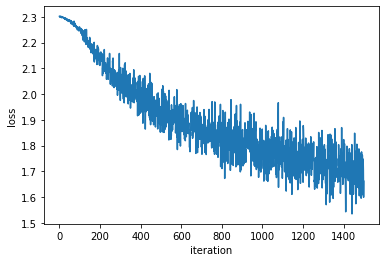

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))

### Section 3.4.1. Different numbers of layers [15 pts]
Try building 3 simple NN with different numbers of layers. Plot the training/validation/test accuracy as a function of the numbers of layers.

In [ ]:
# Your code goes here

class Simple_NN_L3(object):
    
    def __init__(self, input_size, output_size, hidden_state_size1=64,hidden_state_size2=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size1)
        self.activation1 = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size1, hidden_state_size2)
        self.activation2 = nn_ReLU()
        self.linear3 = nn_Linear(hidden_state_size2, output_size)
       
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation1.forward(self.x1)
        self.x2 = self.linear2.forward(self.a1)
        self.a2 = self.activation2.forward(self.x2)
        logits = self.linear3.forward(self.a2)
        return logits
    
    def backward(self, gradOutput):
        
        dx3 = self.linear3.backward(self.a2, gradOutput)
        da2 = self.activation2.backward(self.x2, dx3)
        dx2 = self.linear2.backward(self.a1, da2)
        da1 = self.activation1.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
        self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
class Simple_NN_L4(object):
    
    def __init__(self, input_size, output_size, hidden_state_size1=64,hidden_state_size2=64,hidden_state_size3=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size1)
        self.activation1 = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size1, hidden_state_size2)
        self.activation2 = nn_ReLU()
        self.linear3 = nn_Linear(hidden_state_size2, hidden_state_size3)
        self.activation3 = nn_ReLU()
        self.linear4 = nn_Linear(hidden_state_size3, output_size)
       
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation1.forward(self.x1)
        self.x2 = self.linear2.forward(self.a1)
        self.a2 = self.activation2.forward(self.x2)
        self.x3 = self.linear3.forward(self.a2)
        self.a3 = self.activation3.forward(self.x3)
        logits = self.linear4.forward(self.a3)
        return logits
    
    def backward(self, gradOutput):
        dx4 = self.linear4.backward(self.a3, gradOutput)
        da3 = self.activation3.backward(self.x3, dx4)
        dx3 = self.linear3.backward(self.a2, da3)
        da2 = self.activation2.backward(self.x2, dx3)
        dx2 = self.linear2.backward(self.a1, da2)
        da1 = self.activation1.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
        self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
        self.linear4.weight = self.linear4.weight - lr * (self.linear4.gradWeight)
        self.linear4.bias = self.linear4.bias - lr * (self.linear4.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
# Your code goes here

class Simple_NN_L1(object):
    
    def __init__(self, input_size, output_size):
        self.linear1 = nn_Linear(input_size, output_size)
       
        
    def forward(self, X):
        self.X = X
        logits = self.linear1.forward(self.X)
        return logits
    
    def backward(self, gradOutput):
        self.linear1.backward(self.X, gradOutput)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
       
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
# NN with 1 layers

model1 = Simple_NN_L1(X_train.shape[1], np.max(y_train)+1)
loss_hist = model1.train(X_train, y_train, lr=1e-4)
predict = model1.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model1.predict(X_val)
print('The val accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = model1.predict(X_test)
print('The test accuracy is given by : %f' % (get_acc(predict, y_test)))

Iter 100/1500 - loss: 22.738775437452272 
Iter 200/1500 - loss: 32.08704068191942 
Iter 300/1500 - loss: 23.871890062138835 
Iter 400/1500 - loss: 37.993978801118175 
Iter 500/1500 - loss: 22.306164532859086 
Iter 600/1500 - loss: 27.17117941949563 
Iter 700/1500 - loss: 26.106763770967582 
Iter 800/1500 - loss: 14.181073719506655 
Iter 900/1500 - loss: 36.55338398456621 
Iter 1000/1500 - loss: 24.105474310967402 
Iter 1100/1500 - loss: 26.437776368082723 
Iter 1200/1500 - loss: 24.68718809457583 
Iter 1300/1500 - loss: 26.740882196957017 
Iter 1400/1500 - loss: 28.961251174941616 
Iter 1500/1500 - loss: 36.24804505068966 
The training accuracy is given by : 29.897959
The val accuracy is given by : 29.567797
The test accuracy is given by : 25.600000


In [ ]:
# NN with 2 layers

model2 = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=8)
n_iter = 1000
batch_size = 200
loss_hist = model2.train(X_train, y_train, lr=1e-4)
predict = model2.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model2.predict(X_val)
print('The val accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = model2.predict(X_test)
print('The test accuracy is given by : %f' % (get_acc(predict, y_test)))

Iter 100/1500 - loss: 2.299672467937875 
Iter 200/1500 - loss: 2.276572804416187 
Iter 300/1500 - loss: 2.1431525994050635 
Iter 400/1500 - loss: 2.177233707642621 
Iter 500/1500 - loss: 2.03153081751308 
Iter 600/1500 - loss: 1.9997078408538984 
Iter 700/1500 - loss: 2.0483071121643026 
Iter 800/1500 - loss: 1.9592964414363885 
Iter 900/1500 - loss: 1.8143215129630834 
Iter 1000/1500 - loss: 1.8316111547782439 
Iter 1100/1500 - loss: 1.8199050550117053 
Iter 1200/1500 - loss: 1.7326759460293226 
Iter 1300/1500 - loss: 1.8108587706612962 
Iter 1400/1500 - loss: 1.8210242571482333 
Iter 1500/1500 - loss: 1.8377011425913252 
The training accuracy is given by : 34.624490
The val accuracy is given by : 34.313559
The test accuracy is given by : 33.000000


In [ ]:
# NN with 3 layers

model3 = Simple_NN_L3(X_train.shape[1], np.max(y_train)+1, hidden_state_size1=8,hidden_state_size2=8)
loss_hist = model3.train(X_train, y_train, lr=1e-4)

predict = model3.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model3.predict(X_val)
print('The val accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = model3.predict(X_test)
print('The test accuracy is given by : %f' % (get_acc(predict, y_test)))

Iter 100/1500 - loss: 2.3026178904010997 
Iter 200/1500 - loss: 2.3026437245417686 
Iter 300/1500 - loss: 2.302582529568866 
Iter 400/1500 - loss: 2.302689565027732 
Iter 500/1500 - loss: 2.3026204169730375 
Iter 600/1500 - loss: 2.302564578341034 
Iter 700/1500 - loss: 2.3025691267203725 
Iter 800/1500 - loss: 2.3025392023672455 
Iter 900/1500 - loss: 2.302612062528274 
Iter 1000/1500 - loss: 2.3026315042703414 
Iter 1100/1500 - loss: 2.3026913449279793 
Iter 1200/1500 - loss: 2.3025246779775497 
Iter 1300/1500 - loss: 2.3026099631071917 
Iter 1400/1500 - loss: 2.302555138830874 
Iter 1500/1500 - loss: 2.302542393011137 
The training accuracy is given by : 10.042857
The val accuracy is given by : 9.627119
The test accuracy is given by : 10.000000


In [ ]:
# NN with 4 layers
model4 = Simple_NN_L4(X_train.shape[1], np.max(y_train)+1, hidden_state_size1=8,hidden_state_size2=8,hidden_state_size3=8)
loss_hist = model4.train(X_train, y_train, lr=1e-4)
predict = model4.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model4.predict(X_val)
print('The val accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = model4.predict(X_test)
print('The test accuracy is given by : %f' % (get_acc(predict, y_test)))

Iter 100/1500 - loss: 2.3024872730192523 
Iter 200/1500 - loss: 2.302577568659605 
Iter 300/1500 - loss: 2.3026584466446547 
Iter 400/1500 - loss: 2.302705721176615 
Iter 500/1500 - loss: 2.302579496646442 
Iter 600/1500 - loss: 2.302588591602511 
Iter 700/1500 - loss: 2.3027033337300815 
Iter 800/1500 - loss: 2.3024302865185704 
Iter 900/1500 - loss: 2.3025496476527105 
Iter 1000/1500 - loss: 2.302694060675735 
Iter 1100/1500 - loss: 2.3026255315052513 
Iter 1200/1500 - loss: 2.3025350843127943 
Iter 1300/1500 - loss: 2.3024848354582956 
Iter 1400/1500 - loss: 2.302562690800563 
Iter 1500/1500 - loss: 2.302521810165257 
The training accuracy is given by : 9.995918
The val accuracy is given by : 9.805085
The test accuracy is given by : 11.200000


### Section 3.4.2. Different numbers of hidden state size [10 pts]
Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried. We recommend you to test numbers like 8, 16, 32, 64, 128, 256. Plot the training/validation/test accuracy as a function of the hidden state size your picked.

Iter 100/1000 - loss: 2.297909915475829 
Iter 200/1000 - loss: 2.2388561545909136 
Iter 300/1000 - loss: 2.200816439783287 
Iter 400/1000 - loss: 2.123969371312488 
Iter 500/1000 - loss: 2.0676754900122853 
Iter 600/1000 - loss: 1.9499414776583632 
Iter 700/1000 - loss: 1.978209138503807 
Iter 800/1000 - loss: 1.9090258046484945 
Iter 900/1000 - loss: 1.8898132298521169 
Iter 1000/1000 - loss: 1.9480229640375528 
Iter 100/1000 - loss: 2.2855550397233957 
Iter 200/1000 - loss: 2.1971655470350204 
Iter 300/1000 - loss: 2.1634780348186924 
Iter 400/1000 - loss: 2.0667705313784137 
Iter 500/1000 - loss: 2.0156848016798534 
Iter 600/1000 - loss: 2.034199463031084 
Iter 700/1000 - loss: 2.0711074398880824 
Iter 800/1000 - loss: 1.9171429818946921 
Iter 900/1000 - loss: 2.025497526988913 
Iter 1000/1000 - loss: 1.8830123056237182 
Iter 100/1000 - loss: 2.281240547722744 
Iter 200/1000 - loss: 2.1878476424980304 
Iter 300/1000 - loss: 2.1250964691401584 
Iter 400/1000 - loss: 2.016800373457213

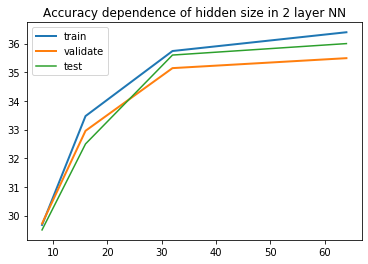

In [ ]:
# Your code goes here

size=[8,16,32,64]
act_train=[]
act_val=[]
act_test=[]
for i in range(4):
    model2 = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=size[i])
    loss_hist = model2.train(X_train, y_train, lr=1e-4,n_iter=1000)
    act_train.append(get_acc(model2.predict(X_train), y_train))
    act_val.append(get_acc(model2.predict(X_val), y_val))
    act_test.append(get_acc(model2.predict(X_test), y_test))

lines = plt.plot(size, act_train, size, act_val, size, act_test)
plt.setp(lines[0], linewidth=2)
plt.setp(lines[1], linewidth=2)
plt.setp(lines[2], markersize=2)

plt.legend(('train', 'validate', 'test'),
           loc='upper left')
plt.title('Accuracy dependence of hidden size in 2 layer NN')
plt.show()


### Section 3.4.3. Different activation functions [10 pts]
Try both ReLU and Sigmoid activation, and report the training/validation/test accuracy.

In [ ]:
# Your code goes here

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x))
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

class Simple_NN_S(Simple_NN):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        super(Simple_NN_S, self).__init__(input_size, output_size, hidden_state_size=64)
        self.activation = nn_Sigmoid()

model_relu = Simple_NN(X_train.shape[1],np.max(y_train)+1,hidden_state_size=64)
loss_relu = model_relu.train(X_train, y_train,lr=1e-4,n_iter=1500)
model_sigmoid = Simple_NN_S(X_train.shape[1],np.max(y_train)+1,hidden_state_size=64)
loss_sigmoid = model_sigmoid.train(X_train, y_train, lr=1e-4,n_iter=1500)

t1=get_acc(model_relu.predict(X_train), y_train)
t2=get_acc(model_sigmoid.predict(X_train), y_train)
print("Train accuracy of Relu:%f and Sigmoid: %f" %(t1, t2)) 
t1=get_acc(model_relu.predict(X_val), y_val)
t2=get_acc(model_sigmoid.predict(X_val), y_val)
print("Val accuracy of Relu:%f and Sigmoid: %f" %(t1, t2)) 
t1=get_acc(model_relu.predict(X_test), y_test)
t2=get_acc(model_sigmoid.predict(X_test), y_test)
print("Test accuracy of Relu:%f and Sigmoid: %f" %(t1, t2)) 

Iter 100/1500 - loss: 2.2572770581443735 
Iter 200/1500 - loss: 2.1352340297469135 
Iter 300/1500 - loss: 2.0438733929622446 
Iter 400/1500 - loss: 1.967142946884166 
Iter 500/1500 - loss: 1.984596331544664 
Iter 600/1500 - loss: 1.8108252189283902 
Iter 700/1500 - loss: 1.8718559515348745 
Iter 800/1500 - loss: 1.8161084096326465 
Iter 900/1500 - loss: 1.7956027606879945 
Iter 1000/1500 - loss: 1.8078966462591484 
Iter 1100/1500 - loss: 1.7697760196691246 
Iter 1200/1500 - loss: 1.779338519404024 
Iter 1300/1500 - loss: 1.8642923286784032 
Iter 1400/1500 - loss: 1.7180513612025698 
Iter 1500/1500 - loss: 1.7111123660443655 
Iter 100/1500 - loss: 2.300908812897937 
Iter 200/1500 - loss: 2.2991983987483513 
Iter 300/1500 - loss: 2.2993819196433396 
Iter 400/1500 - loss: 2.297890898387958 
Iter 500/1500 - loss: 2.295294301651075 
Iter 600/1500 - loss: 2.2943020480689977 
Iter 700/1500 - loss: 2.292141284637336 
Iter 800/1500 - loss: 2.290957731288084 
Iter 900/1500 - loss: 2.287054354234

### Section 3.4.4. What did you see? [5 pts]
Desribe what you see in the experiments above in 5-6 sentences.

In [ ]:
# Your code goes here
import os
print(os.environ['HOME'])

/Users/weicui


By doing these experiments, I notice that 
1. We find the accuracy decreases when we incresing number of layers. 
2. The accuracy increases expotentially when increasing hidden state size. We can find it from the plot above. 
3. The accuracy of NN with ReLU is higher than NN with Sigmoid as activiation function. In our experiment, the accuracy of test dataset is 39.6% for ReLu while only 23.8% for Sigmoid.
